# Natural Language Processing w/ Disaster Tweets

# Step One: Project Overview

In this project, the goal is to build a binary classification model to reliably classify tweets as either having information about a real disaster or not. We are provided a few files that we can use to train and validate the model:  `train.csv`, `test.csv`.

# Step Two: Exploratory Data Analysis

In this section I will be performing EDA to get a better feel for how to work with the data we've been provided with. 

TODO: OVerview of what you did Show a few visualizations like histograms. Describe any data cleaning procedures. Based on your EDA, what is your plan of analysis? 
 
 ## Loading Data From Kaggle

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


In [4]:
# Save data to usable dataframes
train = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
test = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')
sample_submission = pd.read_csv('/kaggle/input/nlp-getting-started/sample_submission.csv')

In [7]:
# Lets look at dimensions: 
print(f"Training data: {train.shape[0]} entries, {train.shape[1]} attributes")
print(f"Validation data: {train.shape[0]} entries, {train.shape[1]} attributes")

# Attributes
print(f"Available attributes: {list(train.columns)}")

Training data: 7613 entries, 5 attributes
Validation data: 7613 entries, 5 attributes
Available attributes: ['id', 'keyword', 'location', 'text', 'target']


In [8]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


Let's get a feel for what values each column has.

In [21]:
import matplotlib.pyplot as plt
def column_values(df: pd.DataFrame, column: str, plot: bool = False) -> None:
    unique_values = df[column].unique()
    nan_count = df[column].isna().sum()
    print(f"{column} | Found {len(unique_values)} unique values and {nan_count} NaN values")
    
    if plot: 
        value_counts = df[column].value_counts()
        top_values  = value_counts.head(50)
        plt.figure(figsize=(12, 3))
        plt.bar(top_values.index.astype(str), top_values.values)
        plt.xlabel('Unique Values')
        plt.ylabel('Count')
        plt.xticks(rotation=90)
        plt.title(f'Value Counts for Column "{column}"')
        plt.show()

keyword | Found 222 unique values and 61 NaN values


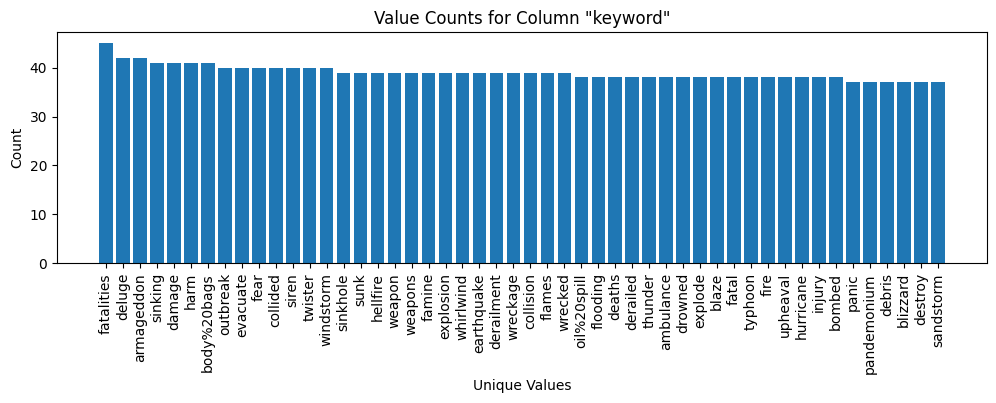

In [22]:
column_values(train, 'keyword', plot=True)

location | Found 3342 unique values and 2533 NaN values


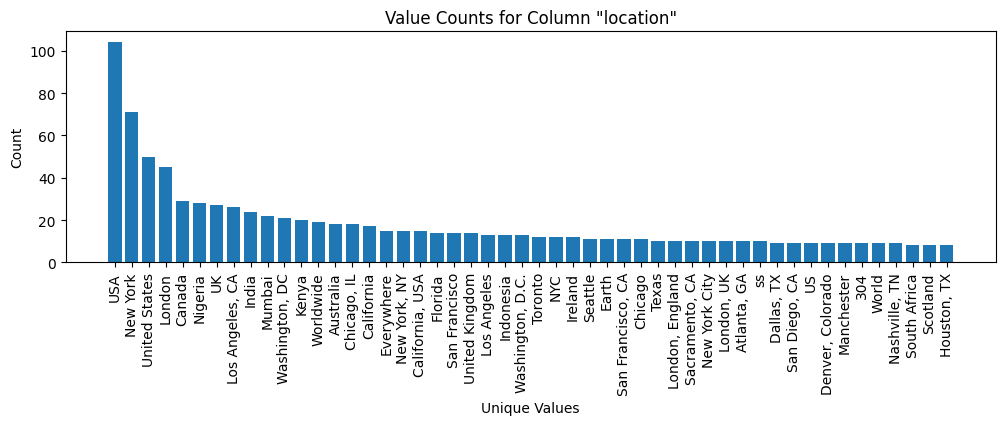

In [23]:
column_values(train, 'location', plot=True)

## A look at the text

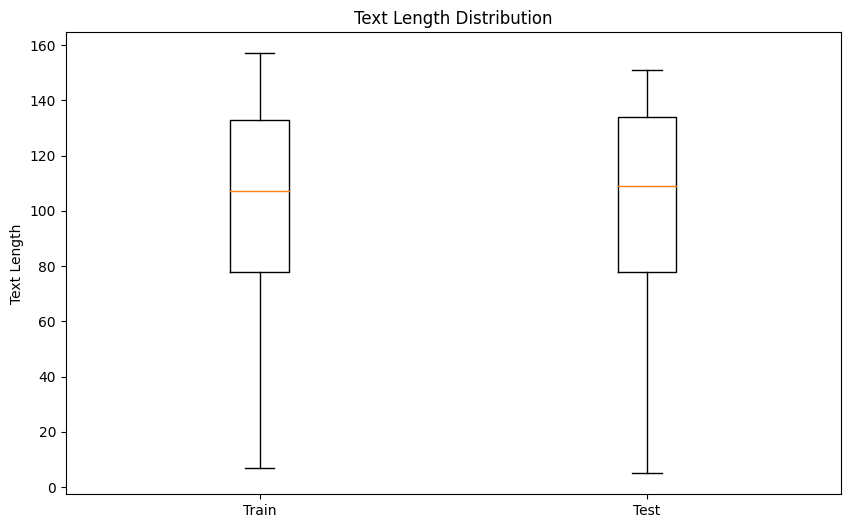

In [32]:
train["text_length"] = train["text"].apply(lambda x : len(x))
test["text_length"] = test["text"].apply(lambda x : len(x))

plt.figure(figsize=(10, 6))
plt.boxplot([train["text_length"], test["text_length"]], labels=['Train', 'Test'])
plt.title('Text Length Distribution')
plt.ylabel('Text Length')
plt.show()


In [26]:
# Let's see what a few tweets look like 
train[['text', 'target']].head(5)

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


# Step Three: Model Architecture (25 pts)
TODO: Describe your model architecture and reasoning for why you believe that specific architecture would be suitable for this problem. 

Since we did not learn NLP-specific techniques such as word embeddings in the lectures, we recommend looking at Kaggle tutorials, discussion boards, and code examples posted for this challenge.  You can use any resources needed, but make sure you “demonstrate” you understood by including explanations in your own words. Also importantly, please have a reference list at the end of the report.  

There are many methods to process texts to matrix form (word embedding), including TF-IDF, GloVe, Word2Vec, etc. Pick a strategy and process the raw texts to word embedding. Briefly explain the method(s) and how they work in your own words.

Build and train your sequential neural network model (You may use any RNN family neural network, including advanced architectures LSTM, GRU, bidirectional RNN, etc.). 

# Step Four: Results and Analysis 

# Step Five: Conclusion